In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd

import sys

sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis/py_functions')

from scipy.stats import norm
from tkinter import *
import scipy
from scipy import signal

import platform
from glob import glob
from scipy.spatial import distance
import basic_func as bf
from scipy.integrate import simps
from numpy import trapz
import IO_func as IOF
import BM_func as BMf
import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path
import LL_funcs as LLf
import freq_funcs as ff
#
from scipy.signal import hilbert, butter, filtfilt
import scipy.stats as stats
from tqdm.notebook import trange, tqdm
import significance_funcs as sig_func

dist_groups = np.array([[0, 30], [30, 60], [60, 120]])
dist_labels = ['local (<30 mm)', 'short (<60mm)', 'long']
Fs = 500
dur = np.zeros((1, 2), dtype=np.int32)
t0 = 1
dur[0, 0] = -t0
dur[0, 1] = 3

folder = 'BrainMapping'
# dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax = np.arange(dur[0, 0], dur[0, 1], (1 / Fs))
color_elab = np.zeros((3, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])
cwd = os.getcwd()

In [2]:
subj = 'EL011'
cond_folder = 'CR'  # Condition = 'Hour', 'Condition', 'Ph'

if cond_folder == 'Ph':
    cond_vals = np.arange(4)
    cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
    cond_colors = ['#494159', '#594157', "#F1BF98", "#8FB996"]
    cond1 = 'Condition'  # 'condition', 'h'
    cond_folder = 'Ph'  # 'Ph', 'Sleep', 'CR'
    Condition = 'Condition'
if cond_folder == 'CR':
    Condition = 'Hour'  # Condition = 'Hour'
    cond1 = 'h'  # h (as stored in stimlist)

######## General Infos

path_patient_analysis = 'y:\\eLab\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
path_gen = os.path.join('y:\\eLab\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_patient, 'infos')
if not os.path.exists(path_infos):
    path_infos = path_gen + '\\infos'

sep = ';'
Fs = 500
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/BM_plot_trial').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/single_con').mkdir(parents=True,
                                                                                              exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/Pipeline').mkdir(parents=True, exist_ok=True)

# get labels
if cond_folder == 'Ph':
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*Ph*')
else:
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*')
i = 0
stimlist = pd.read_csv(files_list[i])
# EEG_resp = np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[i][-11:-4]+'.npy')
lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
    stimlist,
    lbls)

labels_h = lbls.Hemisphere + '_' + labels_all

badchans = pd.read_csv(path_patient_analysis + '\\' + folder + '/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:, 1] == 1))[0, :])

bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
######### Load data
rerun = 0
if os.path.isfile(file_con):
    # con_trial
    con_trial = pd.read_csv(file_con)

In [3]:
# load hypnogram
file_hypno = path_patient_analysis + '/stimlist_hypnogram.csv'
if os.path.isfile(file_hypno):
    stimlist_hypno = pd.read_csv(file_hypno)
len(np.unique(stimlist_hypno.stim_block))

70

print(len(stimlist_hypno[stimlist_hypno.Prot=='BrainMapping']))
print(len(stimlist_hypno[stimlist_hypno.Prot=='InputOutput']))
print(len(stimlist_hypno[stimlist_hypno.Prot=='PairedPulse']))

print(len(stimlist_hypno[stimlist_hypno.sleep==0])/len(stimlist_hypno[stimlist_hypno.sleep<5]))
print(len(stimlist_hypno[(stimlist_hypno.sleep>0)&(stimlist_hypno.sleep<4)])/len(stimlist_hypno[stimlist_hypno.sleep<5]))
print(len(stimlist_hypno[stimlist_hypno.sleep==4])/len(stimlist_hypno[stimlist_hypno.sleep<5]))


In [4]:

##all
cond_vals = np.arange(4)
cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
cond_colors = ['#494159', '#594157', "#F1BF98", "#8FB996"]

In [5]:
if platform.system() == 'Windows':
    # sep = ','
    path = 'y:\eLab\Patients\\'  # + subj
    CR_color = pd.read_excel("T:\EL_experiment\Patients\\" + 'all' + "\Analysis\BrainMapping\CR_color.xlsx",
                             header=0)
    regions = pd.read_excel("Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\elab_labels.xlsx",
                            sheet_name='regions',
                            header=0)

    # path_patient    = 'E:\PhD\EL_experiment\Patients\\'+subj # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
else:  # 'Darwin' for MAC
    path = '/Volumes/EvM_T7/PhD/EL_experiment/Patients/'  # + subj
    CR_color = pd.read_excel("/Volumes/EvM_T7/PhD/EL_experiment/Patients/all/Analysis/BrainMapping/CR_color.xlsx",
                             header=0)
    regions = pd.read_excel("/Volumes/EvM_T7/PhD/EL_experiment/Patients/all/elab_labels.xlsx", sheet_name='regions',
                            header=0)

sep = ';'
color_regions = regions.color.values
C = regions.label.values
cond_folder = 'CR'

In [6]:
#EEG_CR_file = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_'+cond_folder+'.npy'
#EEG_CR = np.load(EEG_CR_file)
#stimlist = pd.read_csv(path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\Stimlist_'+cond_folder+'.csv')

# EEG_CR = np.load(path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_' + cond_folder + '.npy')
# stimlist = pd.read_csv(
#    path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\stimlist_' + cond_folder + '.csv')


# Cohen's D

In [144]:
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

In [ ]:
n = 200
surr_cd = np.zeros((n,))
for i in range(n):
    np.random.shuffle(dat['SS'].values)
    surr_cd[i] = cohen_d(dat.loc[(dat.Sig == 1) & (dat.SS == 'Wake'), 'LL'].values,dat.loc[(dat.Sig == 1) & (dat.SS == 'NREM'), 'LL'].values)
print(np.percentile(surr_cd,1))
print(np.percentile(surr_cd,99))

In [174]:
def CD_surr(dat, feature_rand = 'SleepState', feature_states = ['Wake', 'NREM'], value = 'LL', n=200, p = 1):
    surr_cd = np.zeros((n,))
    for i in range(n):
        np.random.shuffle(dat[feature_rand].values)
        surr_cd[i] = cohen_d(dat.loc[(dat[feature_rand] == feature_states[0]), value].values,dat.loc[(dat[feature_rand] == feature_states[1]), value].values)

    return [np.percentile(surr_cd,p),np.percentile(surr_cd,100-p)]

In [195]:
def R_surr(dat, feature_rand = 'SleepState', feature_states = ['Wake', 'NREM'], value = 'Prob', n=200, p = 1):
    surr_cd = np.zeros((n,))
    for i in range(n):
        np.random.shuffle(dat[feature_rand].values)
        surr_cd[i] = np.mean(dat.loc[(dat[feature_rand] == feature_states[1]),value])/np.mean(dat.loc[(dat[feature_rand] == feature_states[0]),value])

    return [np.percentile(surr_cd,p),np.percentile(surr_cd,100-p)]

In [208]:
ss = 'NREM'

'NREM'

In [225]:
sc = 24
rc = 69
dat = con_trial_sig[(con_trial_sig.Stim == sc) & (con_trial_sig.Chan == rc) & (con_trial_sig.Artefact < 1)]
LL_w = dat.loc[(dat.Sig == 1) & (dat.SleepState == 'Wake'), 'LL'].values
LL_s = dat.loc[
                (dat.Sig == 1) & (dat.SleepState == ss), 'LL'].values
cd = cohen_d(LL_s, LL_w)

print(cd)
CD_sleep(dat[dat.Sig==1], feature_rand = 'SleepState', feature_states = ['Wake', 'NREM'], value = 'LL', n=200, p = 1)

0.10493467559978444


[-0.42721443349820276, 0.3741184449426382]

In [226]:

p_W = np.mean(dat.loc[dat.SleepState=='Wake','Prob'])
p_SS = np.mean(dat.loc[dat.SleepState==ss,'Prob'])
print(p_SS/p_W)
R_surr(dat, feature_rand = 'SleepState', feature_states = ['Wake', 'NREM'], value = 'Prob', n=200, p = 1)

1.0010330578512396


[0.8312697628458499, 1.1409801136363638]

In [199]:
R_surr(dat, feature_rand = 'SleepState', feature_states = ['Wake', 'NREM'], value = 'Prob', n=200, p = 1)

[0.7465515582916507, 1.2501262626262628]

<AxesSubplot:xlabel='d', ylabel='LL_cd'>

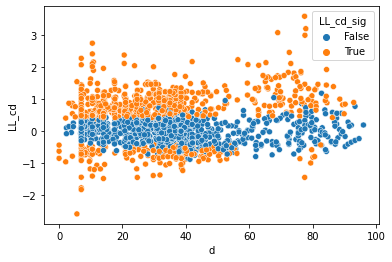

In [230]:
sns.scatterplot(x='d', y= 'LL_cd', hue='LL_cd_sig', data=con_sleep[con_sleep.SleepState=='NREM'])

In [ ]:
file_con_sleep

In [231]:
file_con_sleep = path_patient_analysis + '\\' + folder + '\\' +cond_folder + '\\data\\con_sleep_stats.csv'

In [233]:
dist_groups = np.array([[0, 15], [15, 30], [30, 120]])
dist_labels = ['local (<15 mm)', 'short (<30mm)', 'long']
con_sleep.insert(5, 'Dist', 'long')
for dl, i in zip(dist_labels, np.arange(len(dist_labels))):
    con_sleep.loc[(con_sleep.d < dist_groups[i, 1]) & (con_sleep.d >= dist_groups[i, 0]), 'Dist'] = dist_labels[
        i]

con_sleep.to_csv(file_con_sleep,
                 index=False,
                 header=True)

In [232]:
con_sleep.to_csv(file_con_sleep,
                             index=False,
                             header=True)

In [228]:
con_trial_sig = con_trial[con_trial.d > -10]
con_trial_sig.loc[con_trial_sig.Sig < 0, 'Sig'] = np.nan
con_trial_sig.insert(4, 'LL_sig', np.nan)
con_trial_sig.loc[con_trial_sig.Sig == 1, 'LL_sig'] = con_trial_sig.loc[con_trial_sig.Sig == 1, 'LL']
con_trial_sig = con_trial_sig.drop(columns='LL')
con_trial_sig.insert(4, 'LL', con_trial_sig.LL_sig)
con_trial_sig.insert(4, 'Prob', con_trial_sig.Sig)
con_trial_sig = con_trial_sig.drop(columns='LL_sig')

con_trial_sig = con_trial_sig[np.isin(con_trial_sig.Sig, [0, 1])]
con_sleep = con_trial_sig.groupby(['Stim', 'Chan', 'SleepState'], as_index=False)[['Prob', 'LL', 'd']].mean()
con_sleep.insert(5, 'P_ratio_sig', np.nan)
con_sleep.insert(5, 'LL_cd_sig', np.nan)
con_sleep.insert(5, 'P_ratio', np.nan)
con_sleep.insert(5, 'LL_cd', np.nan)

all_con = con_sleep.groupby(['Stim', 'Chan'], as_index=False)[['Prob']].mean()
all_con = all_con[all_con.Prob>0]


for sc,rc in zip(all_con.Stim.values.astype('int'),all_con.Chan.values.astype('int')):
    dat = con_trial_sig[(con_trial_sig.Stim == sc) & (con_trial_sig.Chan == rc) & (con_trial_sig.Artefact < 1)]
    p_W = np.mean(dat.loc[dat.SleepState=='Wake','Prob'])
    LL_w = dat.loc[(dat.Sig == 1) & (dat.SleepState == 'Wake'), 'LL'].values
    ix_wake = \
        np.where(con_sleep.loc[(con_sleep.Stim == sc) & (con_sleep.Chan == rc), 'SleepState'] == 'Wake')[0]
    for ss, s_ix in zip(['NREM', 'REM'], np.arange(2)):
        ix_sleep = \
            np.where(con_sleep.loc[(con_sleep.Stim == sc) & (con_sleep.Chan == rc), 'SleepState'] == ss)[0]
        if (len(ix_wake) > 0) & (len(ix_sleep) > 0):
            LL_s = dat.loc[
                (dat.Sig == 1) & (dat.SleepState == ss), 'LL'].values
            p_SS = np.mean(dat.loc[dat.SleepState==ss,'Prob'])
            # prob ratio
            r = p_SS/p_W
            sig_thr = R_surr(dat, feature_states = ['Wake', ss])
            con_sleep.loc[(con_sleep.SleepState == ss) & (con_sleep.Stim == sc) & (
                    con_sleep.Chan == rc), 'P_ratio'] = r
            con_sleep.loc[(con_sleep.SleepState == ss) & (con_sleep.Stim == sc) & (
                    con_sleep.Chan == rc), 'P_ratio_sig'] =(r<sig_thr[0])| (r>sig_thr[1])
            # cohen's d
            cd = cohen_d(LL_s, LL_w)
            con_sleep.loc[(con_sleep.SleepState == ss) & (con_sleep.Stim == sc) & (
                    con_sleep.Chan == rc), 'LL_cd'] = cd
            sig_thr = CD_sleep(dat[dat.Sig==1], feature_states = ['Wake', ss])
            con_sleep.loc[(con_sleep.SleepState == ss) & (con_sleep.Stim == sc) & (
                    con_sleep.Chan == rc), 'LL_cd_sig'] =(cd<sig_thr[0])| (cd>sig_thr[1])
            
    con_sleep.loc[
        (con_sleep.SleepState == 'Wake') & (con_sleep.Stim == sc) & (con_sleep.Chan == rc), 'P_ratio'] = 1
    con_sleep.loc[(con_sleep.SleepState == 'Wake') & (con_sleep.Stim == sc) & (
            con_sleep.Chan == rc), 'LL_cd'] = 0  # no change

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: Runtim

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: Runtim

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\core\f

In [140]:
n = 200
surr_cd = np.zeros((n,))
for i in range(n):
    np.random.shuffle(dat['SS'].values)
    surr_cd[i] = cohen_d(dat.loc[(dat.Sig == 1) & (dat.SS == 'Wake'), 'LL'].values,dat.loc[(dat.Sig == 1) & (dat.SS == 'NREM'), 'LL'].values)
print(np.percentile(surr_cd,1))
print(np.percentile(surr_cd,99))

-0.35800482850654153
0.3244135182087467


<AxesSubplot:xlabel='SleepState', ylabel='LL'>

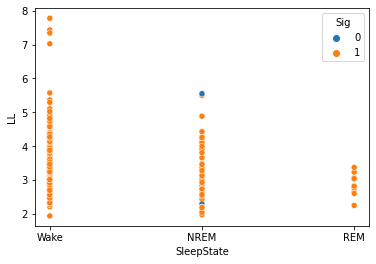

In [132]:
sns.scatterplot(x='SleepState', y= 'LL', hue='Sig', data=dat)

In [30]:
p_NREM

0.0013308676826403677

In [29]:
d_NREM

-3.400259389996089

-1.005206382756809

### General: In-/Out degree

In [37]:
folder = 'BrainMapping'
cond_folder = 'CR'
subjs = ['EL019','EL017', 'EL010', 'EL011', 'EL015', 'EL014', 'EL016']

In [56]:
G = con_trial.groupby(['Stim','Chan','SleepState'], as_index=False)[['Sig','LLz','LLs', 'd']].mean()
metrics = ['Sig','LLz','LLs']
G_in = G.groupby(['Chan','SleepState'], as_index=False)[metrics].sum()
G_in.insert(3,'Deg', 'in')
G_out = G.groupby(['Stim','SleepState'], as_index=False)[metrics].sum()
G_out.insert(3,'Deg', 'out')
G_out.insert(0,'Chan', G_out.Stim)
G_deg = pd.concat([G_in,G_out])
G_deg = G_deg.reset_index(drop=True)
G_deg = G_deg.drop(columns=['Stim'])

In [57]:
means_stds = G_deg.groupby(['Chan','Deg','SleepState'])[m].agg(['mean','std']).reset_index()
means_stds = means_stds[means_stds.SleepState=='Wake']
means_stds = means_stds.drop(columns=['SleepState'])

In [58]:
G_deg.merge(means_stds,on=['Chan','Deg'])

,Chan,SleepState,Sig,Deg,LLz,LLs,mean,std
0,0.0,NREM,16.548496,in,7.004140,94.448347,6.498400,NaN
1,0.0,REM,14.069553,in,5.600939,78.637626,6.498400,NaN
2,0.0,Wake,16.031474,in,6.498400,89.007612,6.498400,NaN
3,1.0,NREM,16.640550,in,5.827166,85.481545,5.619837,NaN
4,1.0,REM,14.184502,in,4.508333,67.459285,5.619837,NaN
...,...,...,...,...,...,...,...,...
358,87.0,REM,9.800000,out,3.584243,40.245164,3.609203,NaN
359,87.0,Wake,9.230769,out,3.609203,39.537149,3.609203,NaN
360,88.0,NREM,7.220588,out,2.683150,24.629744,2.946430,NaN
361,88.0,REM,6.600000,out,2.273229,21.818691,2.946430,NaN


In [59]:
data_con_file = 'Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\Sleep\degree\\data_con.csv'
if os.path.exists(data_con_file)*0:
    data_con = pd.read_csv(data_con_file)
else:
    for i in range(len(subjs)):
        print('loading -- ' + subjs[i], end='\r')
        subj = subjs[i]
        path_gen = os.path.join('y:\\eLab\Patients\\' + subj)
        if not os.path.exists(path_gen):
            path_gen = 'T:\\EL_experiment\\Patients\\' + subj
        path_patient = path_gen + '\Data\EL_experiment'
        path_infos = os.path.join(path_patient, 'infos')
        if not os.path.exists(path_infos):
            path_infos = path_gen + '\\infos'
        path_patient_analysis = 'y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj

        file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
        con_trial = pd.read_csv(file_con)

        lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
        labels_all = lbls.label.values
        labels_clinic = lbls.Clinic.values
        labels_region = lbls.Region.values
        labels_region[labels_region == 'HIPP'] = 'Mesiotemporal'
        labels_region[labels_region == 'HIPP '] = 'Mesiotemporal'
        labels_region[labels_region == 'ENT'] = 'Basotemporal'
        bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

        # data_A = data_A[~np.isin(data_A.Chan,bad_all)&~np.isin(data_A.Stim,bad_all)]
        
        con_trial = con_trial[con_trial.Sig>=0]
        con_trial.loc[con_trial.SleepState=='W','SleepState'] = 'Wake'
        con_trial.insert(3,'LLs', con_trial.LL*con_trial.Sig)
        con_trial.insert(3,'LLz', con_trial.LL*con_trial.Sig)
        con_trial['LLz'] = con_trial.groupby(['Stim','Chan'])['LLs'].transform(lambda x: (x / x.max()))
        
        G = con_trial.groupby(['Stim','Chan','SleepState'], as_index=False)[['Sig','LLz','LLs', 'd']].mean()
        metrics = ['Sig','LLz','LLs']
        G_in = G.groupby(['Chan','SleepState'], as_index=False)[metrics].sum()
        G_in.insert(3,'Deg', 'in')
        G_out = G.groupby(['Stim','SleepState'], as_index=False)[metrics].sum()
        G_out.insert(3,'Deg', 'out')
        G_out.insert(0,'Chan', G_out.Stim)
        G_deg = pd.concat([G_in,G_out])
        G_deg = G_deg.reset_index(drop=True)
        G_deg = G_deg.drop(columns=['Stim'])
        
        for m in metrics:
            means_stds = G_deg.groupby(['Chan','Deg','SleepState'])[m].agg(['mean','std']).reset_index()
            means_stds = means_stds[means_stds.SleepState=='Wake']
            means_stds = means_stds.drop(columns=['SleepState'])
            G_deg = G_deg.merge(means_stds,on=['Chan','Deg'])
            G_deg[m+'_n'] = (G_deg[m] / G_deg['mean']) 
            G_deg = G_deg.drop(columns=['mean', 'std'])
        
        G_deg.insert(0,'Area','Test')
        for c in np.unique(G_deg.Chan.values.astype('int')):
            G_deg.loc[G_deg.Chan==c,'Area']= labels_region[c]
        G_deg.insert(0,'Subj', subj)
        if i == 0:
            data_con = G_deg
        else:
            data_con = pd.concat([data_con, G_deg])
            data_con = data_con.reset_index(drop=True)
        
    data_con.to_csv(data_con_file,
        header=True, index=False)

(0.5, 2.0)

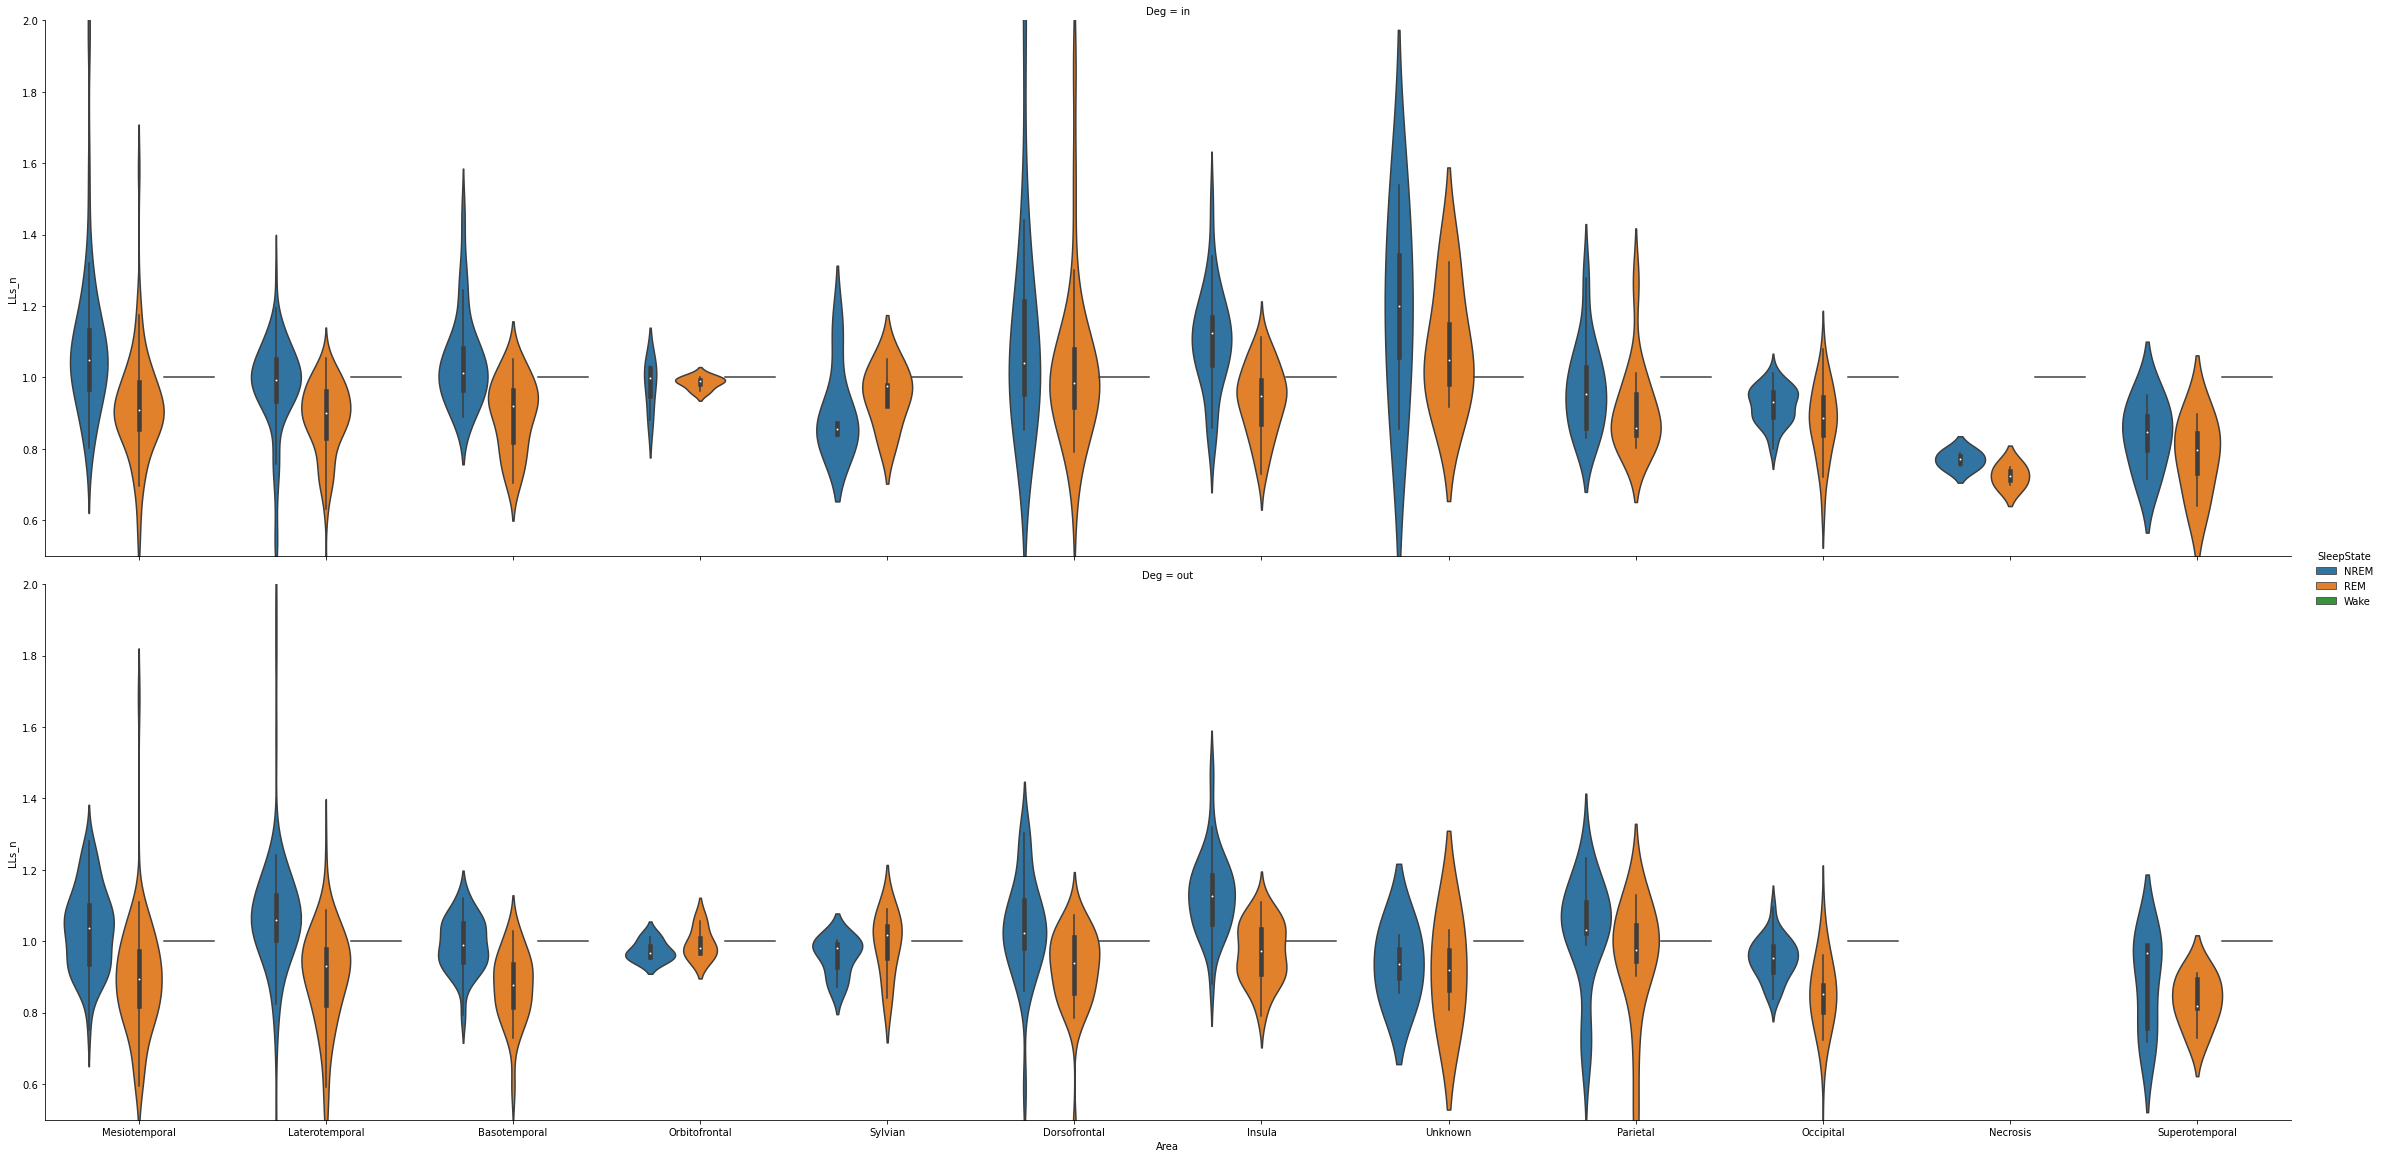

In [61]:
sns.catplot(x ='Area', y='LLs_n', hue='SleepState', data= data_con, row = 'Deg', kind='violin',s=10,height=8,aspect= 4)
plt.ylim([0.5,2])

(0.75, 1.3335)

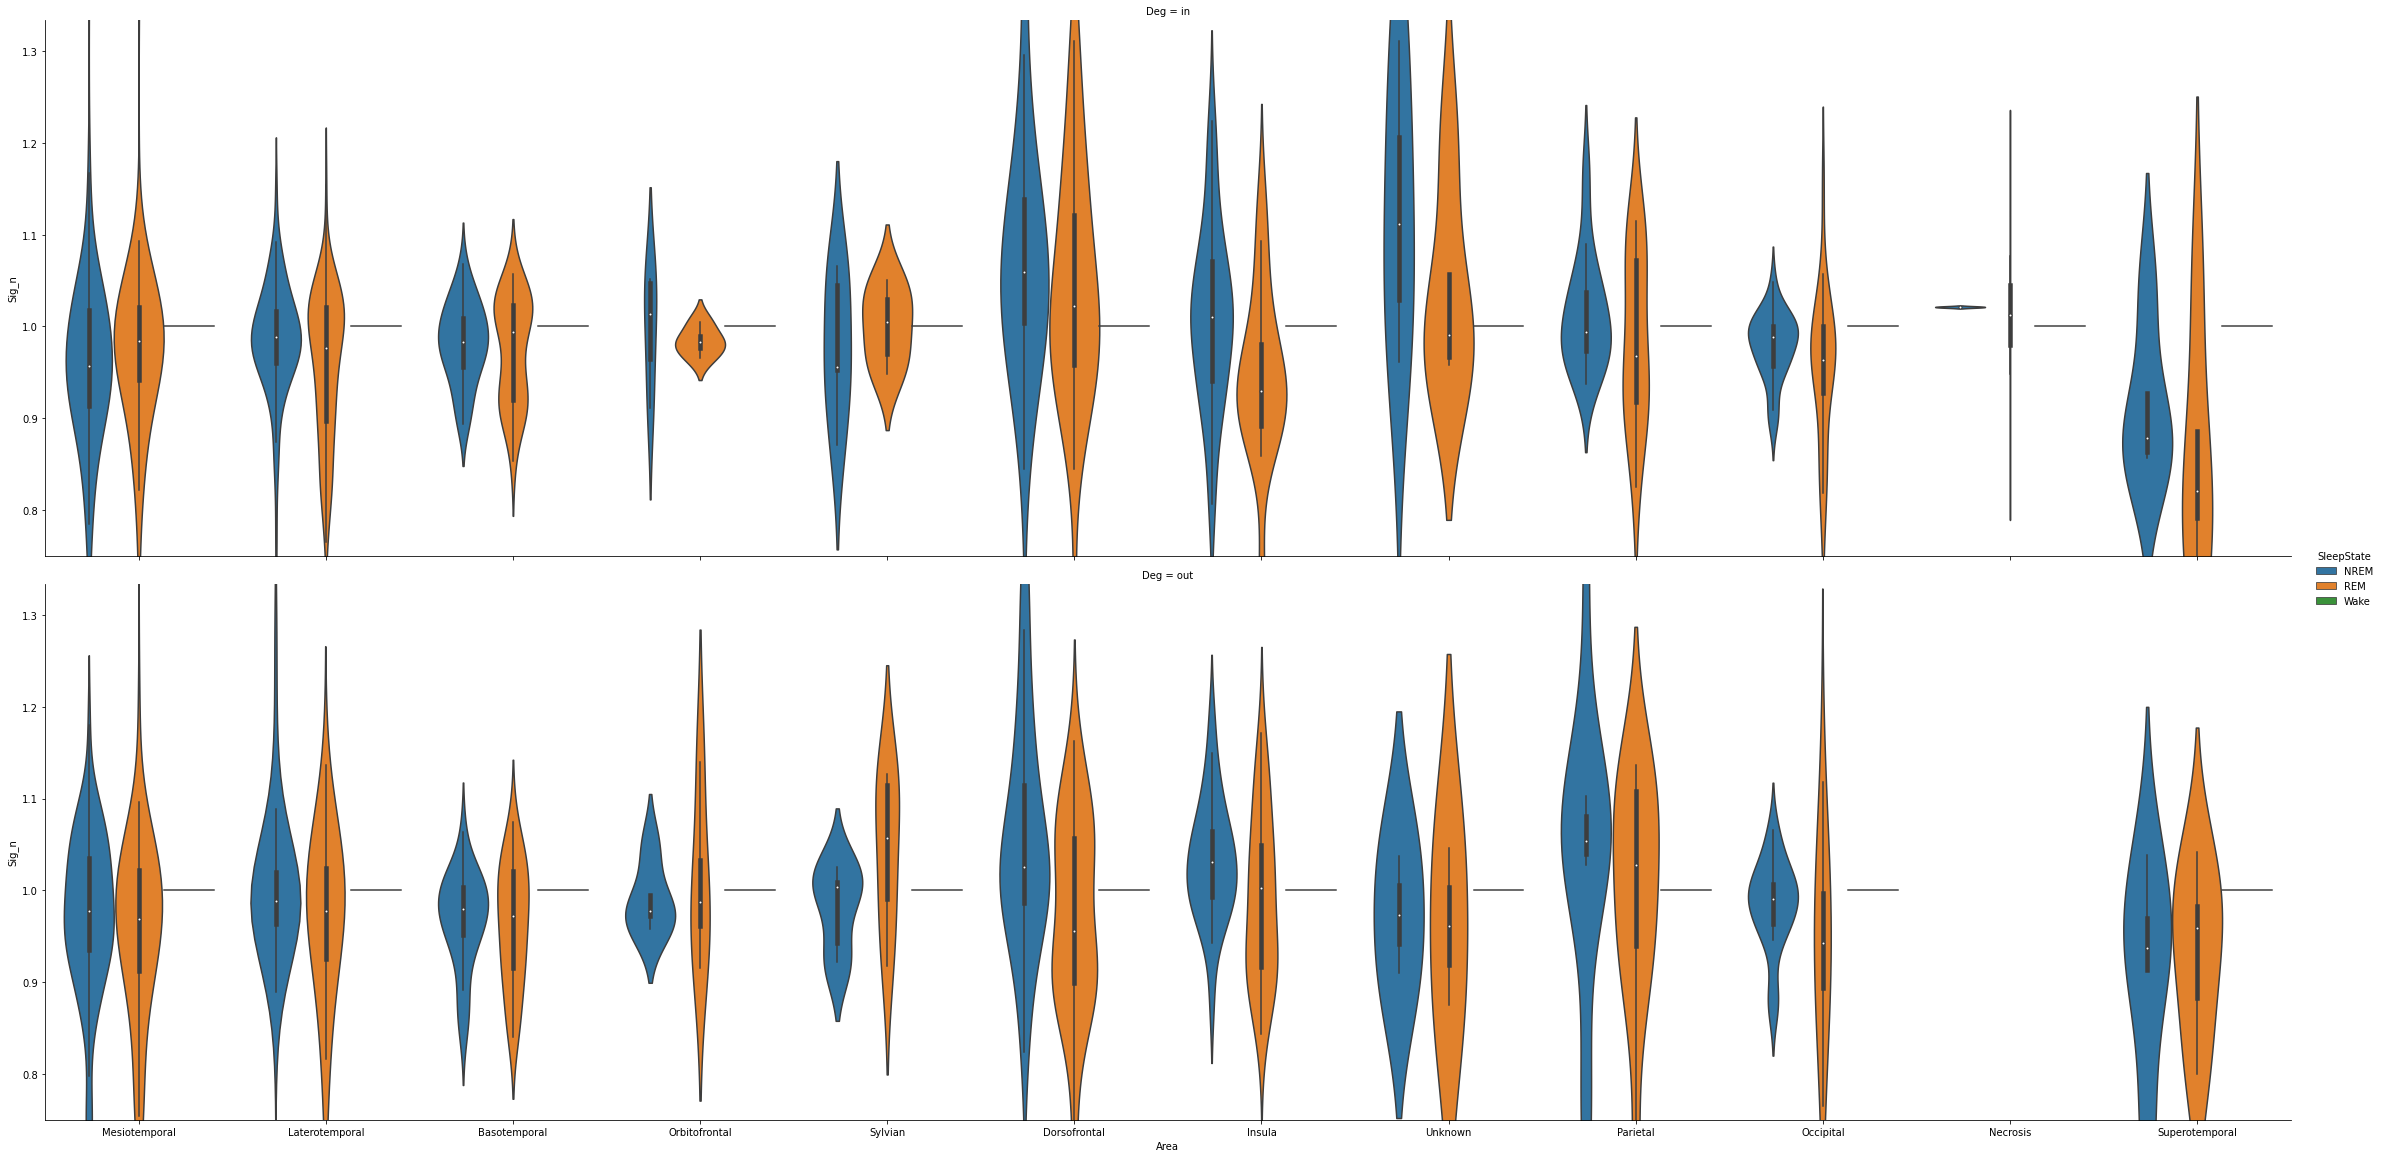

In [63]:
sns.catplot(x ='Area', y='Sig_n', hue='SleepState', data= data_con, row = 'Deg', kind='violin', s=10,height=8,aspect= 4)
plt.ylim([0.75,1.3335])